<table border="0">
    <tr>
        <td>
            <img src="https://ictd2016.files.wordpress.com/2016/04/microsoft-research-logo-copy.jpg" style="width 30px;" />
             </td>
        <td>
            <img src="https://www.microsoft.com/en-us/research/wp-content/uploads/2016/12/MSR-ALICE-HeaderGraphic-1920x720_1-800x550.jpg" style="width 100px;"/></td>
        </tr>
</table>

# ForestDML, ForestDRLearner, OrthoForest and CausalForest: Basic Example

We depict the performance of our `ForestDML`, `ForestDRLearner`, `OrthoForest` and `CausalForest` estimators on the same data generating process as the one used in the tutorial page of the grf package (see https://github.com/grf-labs/grf#usage-examples). This is mostly for qualitative comparison and verification purposes among our implementation of variants of Causal Forests and the implementation in the grf R package.

In [1]:
# Helper imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# DGP

We use the following data generating process (DGP) from [here](https://github.com/grf-labs/grf#usage-examples):

\begin{align}
X \sim& \text{Normal}(0,\, I_{p})\\
T =& \text{Binomial}(1, .4 + .2 \cdot 1\{X[0] > 0\})\\
Y =& (X[0] \cdot 1\{X[0] > 0\}) \cdot T + X[1] + X[2] \cdot 1\{X[2] < 0\} + \epsilon, &\; \epsilon \sim \text{Normal}(0, 1)\\
\end{align}

We use $p=10$ and draw $n=2000$ samples from this DGP.

X T Y 

In [2]:
import numpy as np
import scipy.special

np.random.seed(123)
n = 2000
p = 10
X = np.random.normal(size=(n, p))
true_propensity = lambda x: 0.4 + 0.2 * (x[:, 0] > 0)
true_effect = lambda x: (x[:, 0] * (x[:, 0] > 0))
true_conf = lambda x: x[:, 1] + np.clip(x[:, 2], -np.inf, 0)
T = np.random.binomial(1, true_propensity(X))
Y = true_effect(X) * T + true_conf(X) + np.random.normal(size=(n,))

### Cross-Validated Forest Nuisance Models

We use forest based estimators (Gradient Boosted Fåorests or Random Forests) as nuisance models. For the meta-learner versions of our forest based estimators, we also use a generic forest estimator even as a final model. The hyperparameters of the forest models (e.g. number of estimators, max depth, min leaf size) is chosen via cross validation. We also choose among Gradient or Random Forests via cross validation

In [7]:
from econml.sklearn_extensions.model_selection import GridSearchCVList
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.base import clone
from econml.sklearn_extensions.linear_model import WeightedLasso


def first_stage_reg():
    return GridSearchCVList(
        [
            Lasso(),
            RandomForestRegressor(n_estimators=100, random_state=123),
            GradientBoostingRegressor(random_state=123),
        ],
        param_grid_list=[
            {"alpha": [0.001, 0.01, 0.1, 1, 10]},
            {"max_depth": [3, None], "min_samples_leaf": [10, 50]},
            {"n_estimators": [50, 100], "max_depth": [3], "min_samples_leaf": [10, 30]},
        ],
        cv=5,
        scoring="neg_mean_squared_error",
    )


def first_stage_clf():
    return GridSearchCVList(
        [
            LogisticRegression(),
            RandomForestClassifier(n_estimators=100, random_state=123),
            GradientBoostingClassifier(random_state=123),
        ],
        param_grid_list=[
            {"C": [0.01, 0.1, 1, 10, 100]},
            {"max_depth": [3, 5], "min_samples_leaf": [10, 50]},
            {"n_estimators": [50, 100], "max_depth": [3], "min_samples_leaf": [10, 30]},
        ],
        cv=5,
        scoring="neg_mean_squared_error",
    )


def final_stage():
    return GridSearchCVList(
        [WeightedLasso(), RandomForestRegressor(n_estimators=100, random_state=123)],
        param_grid_list=[
            {"alpha": [0.001, 0.01, 0.1, 1, 10]},
            {"max_depth": [3, 5], "min_samples_leaf": [10, 50]},
        ],
        cv=5,
        scoring="neg_mean_squared_error",
    )


model_y = clone(first_stage_reg().fit(X, Y).best_estimator_)
print(model_y)

model_t = clone(first_stage_clf().fit(X, T).best_estimator_)
print(model_t)

GradientBoostingRegressor(min_samples_leaf=30, n_estimators=50,
                          random_state=123)
RandomForestClassifier(max_depth=3, min_samples_leaf=10, random_state=123)


# DML Estimators

In [8]:
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.dummy import DummyRegressor, DummyClassifier

n_samples, n_features = X.shape
subsample_fr_ = (n_samples / 2) ** (1 - 1 / (2 * n_features + 2)) / (n_samples / 2)
est = CausalForestDML(
    model_y=model_y,
    model_t=model_t,
    discrete_treatment=True,
    cv=3,
    n_estimators=4000,
    random_state=123,
)
est.tune(Y, T, X=X).fit(Y, T, X=X, cache_values=True)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [9]:
from econml.dml import NonParamDML

est2 = NonParamDML(
    model_y=model_y,
    model_t=model_t,
    cv=3,
    discrete_treatment=True,
    model_final=final_stage(),
)
est2.fit(Y, T, X=X)

In [10]:
X_test = np.zeros((100, p))
X_test[:, 0] = np.linspace(-2, 2, 100)

In [11]:
pred = est.effect(X_test)
lb, ub = est.effect_interval(X_test, alpha=0.01)

In [12]:
pred2 = est2.effect(X_test)

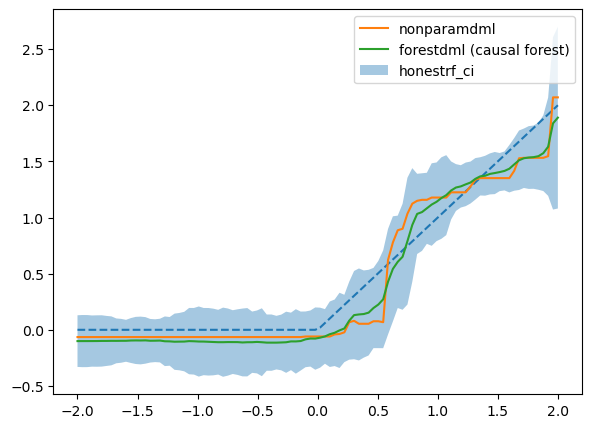

In [13]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(X_test[:, 0], true_effect(X_test), "--")
plt.plot(X_test[:, 0], pred2, label="nonparamdml")
plt.plot(X_test[:, 0], pred, label="forestdml (causal forest)")
plt.fill_between(X_test[:, 0], lb, ub, alpha=0.4, label="honestrf_ci")
plt.legend()
plt.show()

In [14]:
np.mean((true_effect(X) - est.effect(X)) ** 2)

In [15]:
np.mean((true_effect(X) - est2.effect(X)) ** 2)

### First Stage Learned Models

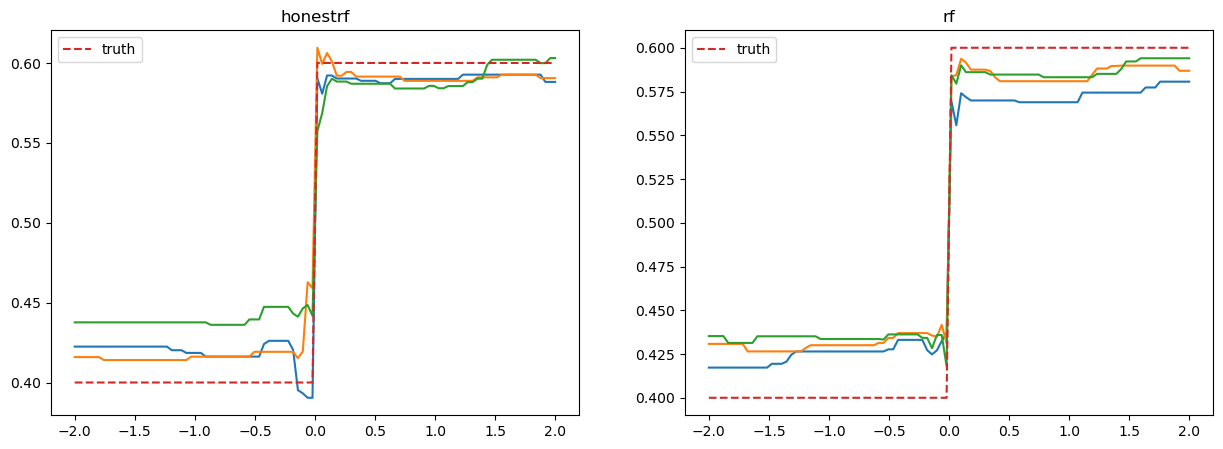

In [16]:
# Model T
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("honestrf")
for mdls in est.models_t:
    for mdl in mdls:
        plt.plot(X_test[:, 0], mdl.predict_proba(X_test)[:, 1])
plt.plot(X_test[:, 0], true_propensity(X_test), "--", label="truth")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("rf")
for mdls in est2.models_t:
    for mdl in mdls:
        plt.plot(X_test[:, 0], mdl.predict_proba(X_test)[:, 1])
plt.plot(X_test[:, 0], true_propensity(X_test), "--", label="truth")
plt.legend()
plt.show()

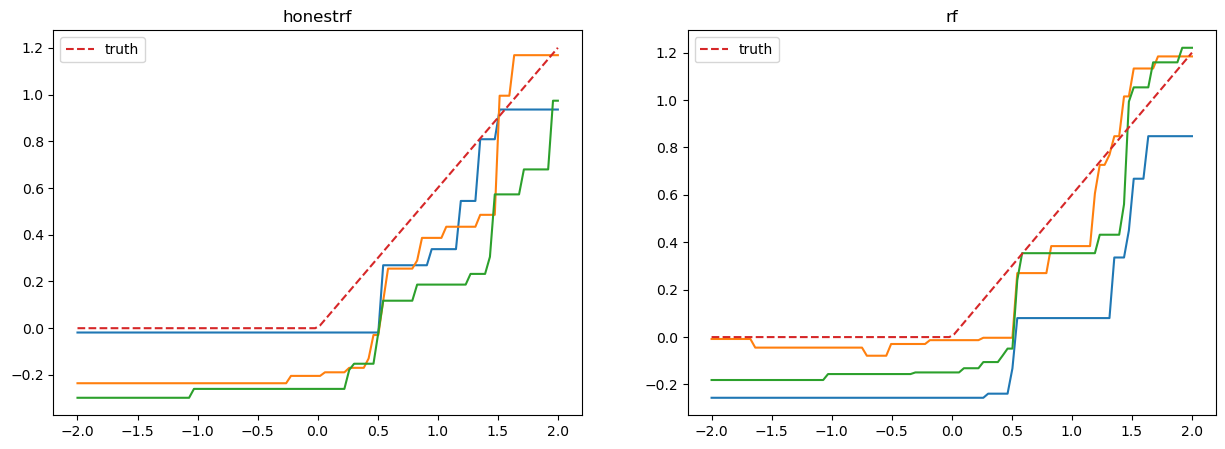

In [17]:
# Model Y
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("honestrf")
for mdls in est.models_y:
    for mdl in mdls:
        plt.plot(X_test[:, 0], mdl.predict(X_test))
plt.plot(
    X_test[:, 0],
    true_effect(X_test) * true_propensity(X_test) + true_conf(X_test),
    "--",
    label="truth",
)
plt.legend()

plt.subplot(1, 2, 2)
plt.title("rf")
for mdls in est2.models_y:
    for mdl in mdls:
        plt.plot(X_test[:, 0], mdl.predict(X_test))
plt.plot(
    X_test[:, 0],
    true_effect(X_test) * true_propensity(X_test) + true_conf(X_test),
    "--",
    label="truth",
)
plt.legend()
plt.show()

### Interpretability of CATE Model of NonParamDML with SHAP

In [18]:
import shap
import string

feature_names = list(string.ascii_lowercase)[: X.shape[1]]
# explain the model's predictions using SHAP values
shap_values = est.shap_values(X[:100], feature_names=feature_names)

 97%|=================== | 97/100 [00:22<00:00]       

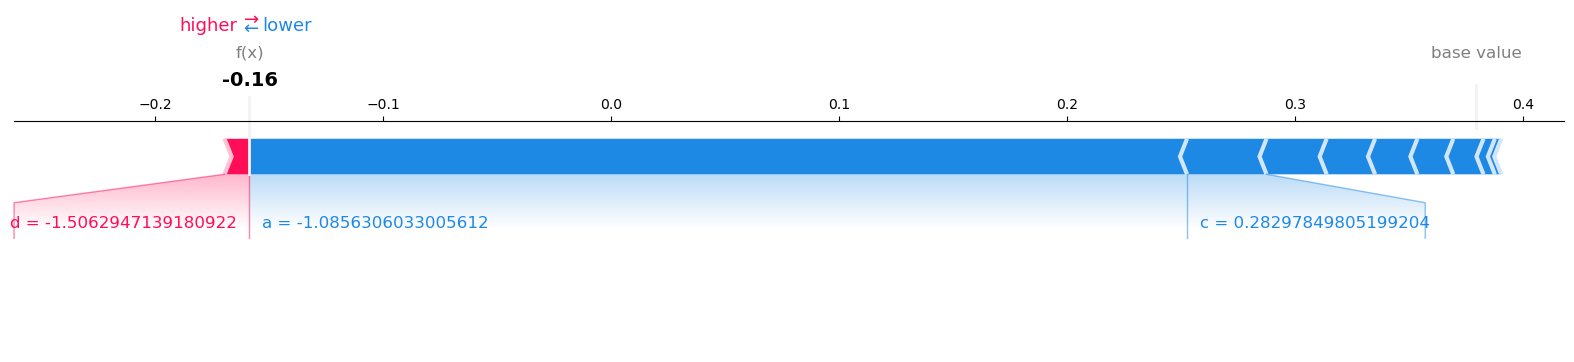

In [19]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(shap_values["Y0"]["T0_1"][0], matplotlib=True)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


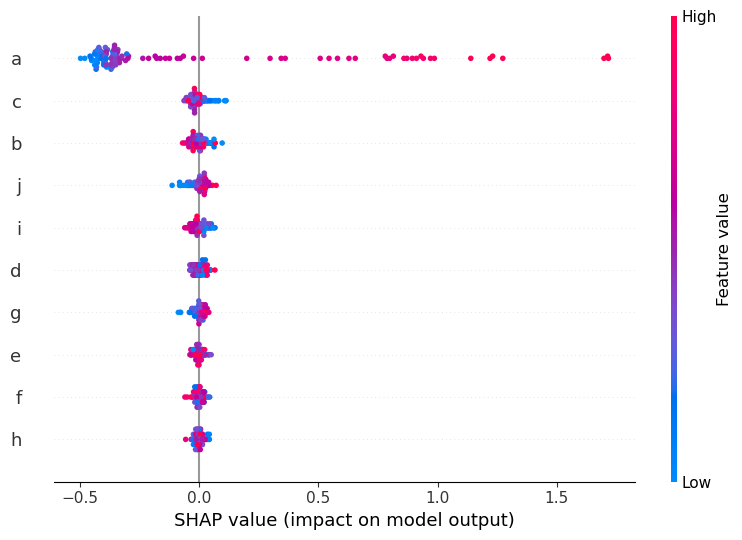

In [20]:
shap.summary_plot(shap_values["Y0"]["T0_1"])

# DRLearner

In [20]:
model_regression = clone(
    first_stage_reg().fit(np.hstack([T.reshape(-1, 1), X]), Y).best_estimator_
)
model_regression

GradientBoostingRegressor(min_samples_leaf=30, n_estimators=50,
                          random_state=123)

In [21]:
from econml.dr import ForestDRLearner
from sklearn.dummy import DummyRegressor, DummyClassifier

est = ForestDRLearner(
    model_regression=model_y,
    model_propensity=model_t,
    cv=3,
    n_estimators=4000,
    min_samples_leaf=10,
    verbose=0,
    min_weight_fraction_leaf=0.005,
)
est.fit(Y, T, X=X)

In [22]:
from econml.dr import DRLearner

est2 = DRLearner(
    model_regression=model_y, model_propensity=model_t, model_final=final_stage(), cv=3
)
est2.fit(Y, T.reshape((-1, 1)), X=X)

In [23]:
X_test = np.zeros((100, p))
X_test[:, 0] = np.linspace(-2, 2, 100)

In [24]:
pred = est.effect(X_test)
lb, ub = est.effect_interval(X_test, alpha=0.01)

In [25]:
pred2 = est2.effect(X_test)

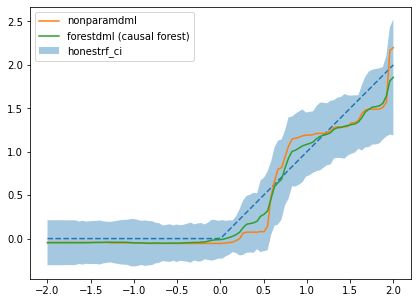

In [26]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(X_test[:, 0], true_effect(X_test), "--")
plt.plot(X_test[:, 0], pred2, label="nonparamdml")
plt.plot(X_test[:, 0], pred, label="forestdml (causal forest)")
plt.fill_between(X_test[:, 0], lb, ub, alpha=0.4, label="honestrf_ci")
plt.legend()
plt.show()

### First stage nuisance models

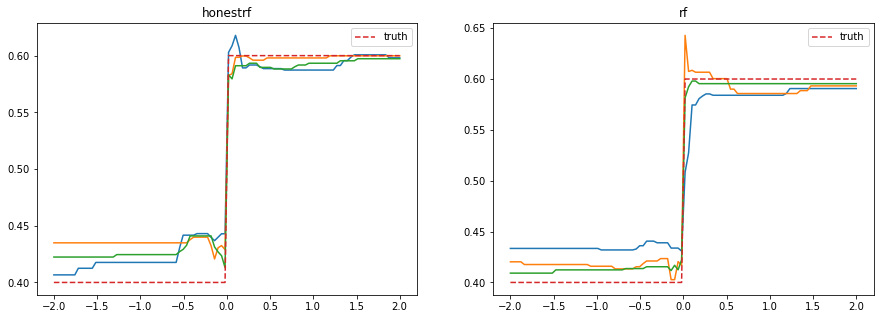

In [27]:
# Model T
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("honestrf")
for mdls in est.models_propensity:
    for mdl in mdls:
        plt.plot(X_test[:, 0], mdl.predict_proba(X_test)[:, 1])
plt.plot(X_test[:, 0], true_propensity(X_test), "--", label="truth")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("rf")
for mdls in est2.models_propensity:
    for mdl in mdls:
        plt.plot(X_test[:, 0], mdl.predict_proba(X_test)[:, 1])
plt.plot(X_test[:, 0], true_propensity(X_test), "--", label="truth")
plt.legend()
plt.show()

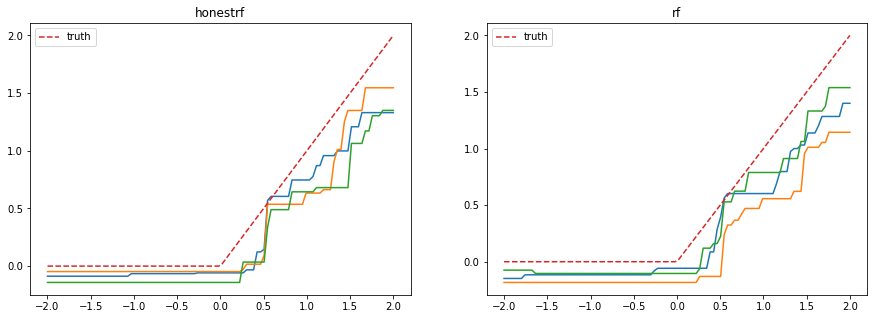

In [28]:
# Model Y
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("honestrf")
for mdls in est.models_regression:
    for mdl in mdls:
        plt.plot(
            X_test[:, 0],
            mdl.predict(np.hstack([X_test, np.ones((X_test.shape[0], 1))])),
        )
plt.plot(X_test[:, 0], true_effect(X_test) + true_conf(X_test), "--", label="truth")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("rf")
for mdls in est2.models_regression:
    for mdl in mdls:
        plt.plot(
            X_test[:, 0],
            mdl.predict(np.hstack([X_test, np.ones((X_test.shape[0], 1))])),
        )
plt.plot(X_test[:, 0], true_effect(X_test) + true_conf(X_test), "--", label="truth")
plt.legend()
plt.show()

### Interpretability of CATE Model of DRLearner with SHAP

In [29]:
# explain the model's predictions using SHAP values
shap_values = est.shap_values(X[:100], feature_names=feature_names)

 98%|===================| 98/100 [00:24<00:00]        

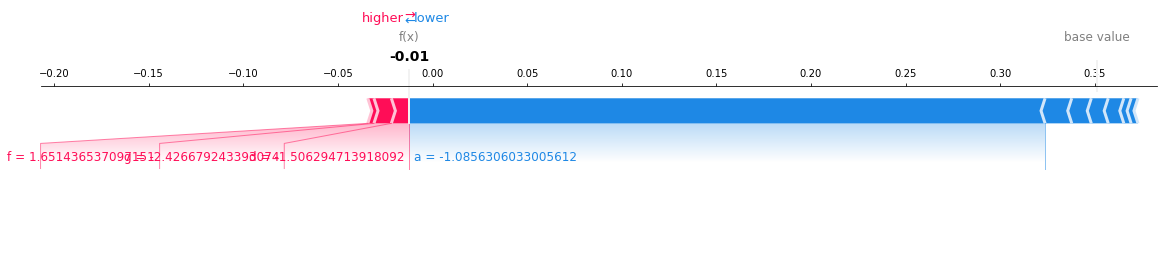

In [30]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(shap_values["Y0"]["T0_1"][0], matplotlib=True)

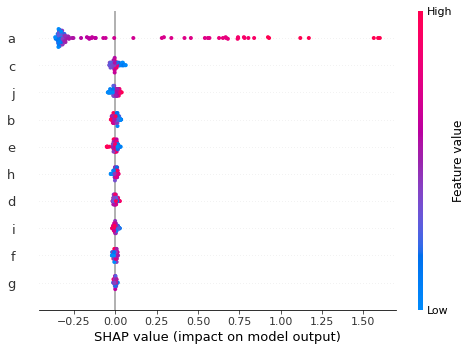

In [31]:
shap.summary_plot(shap_values["Y0"]["T0_1"])

# OrthoForest

In [21]:
from econml.orf import DROrthoForest
from sklearn.linear_model import (
    Lasso,
    LassoCV,
    LogisticRegression,
    LogisticRegressionCV,
)
from econml.sklearn_extensions.linear_model import WeightedLassoCV

est3 = DROrthoForest(
    model_Y=Lasso(alpha=0.01),
    propensity_model=LogisticRegression(C=1),
    model_Y_final=WeightedLassoCV(cv=3),
    propensity_model_final=LogisticRegressionCV(cv=3),
    n_trees=1000,
    min_leaf_size=10,
)
est3.fit(Y, T, X=X)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 182 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   27.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 524 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.2s finished


In [22]:
pred3 = est3.effect(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished


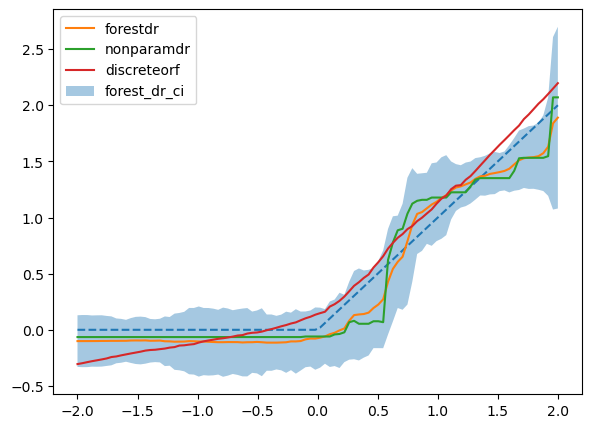

In [23]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(X_test[:, 0], true_effect(X_test), "--")
plt.plot(X_test[:, 0], pred, label="forestdr")
plt.plot(X_test[:, 0], pred2, label="nonparamdr")
plt.plot(X_test[:, 0], pred3, label="discreteorf")
plt.fill_between(X_test[:, 0], lb, ub, alpha=0.4, label="forest_dr_ci")
plt.legend()
plt.show()